## Predicting the Helpfulness of Amazon Fine Food Reviews
https://www.kaggle.com/ameeamin/using-k-means-clustering-to-predict-helpfulness?select=Reviews.csv

### Purpose
Build a model to predict the helpfulness of Amazon Fine Food Reviews. This will improve Amazon's selection of helpful reviews at the top of the review section and improve customer's purchasing decisions. It could also help other reviewers as a guide to writing helpful reviews.

This dataset comes from over 568,0454 Amazon Fine Food Reviews. 

Variable: Description | Type of Variable

HelpfulnessNumerator: number of users who found the review helpful | continuous

HelpfulnessDenominator: number of users who indicated whether they found the review helpful or not helpful | continuous

Score: rating between 1 and 5 | categorical

Text: text of the review | text

## Load the Data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read data into a DataFrame
data = pd.read_csv("../data/Reviews.csv")

#make a copy of columns I need from raw data
df1 = data.iloc[:, [4,5,6,9]]
df1.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy at a great price. There was a wid...


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   HelpfulnessNumerator    568454 non-null  int64 
 1   HelpfulnessDenominator  568454 non-null  int64 
 2   Score                   568454 non-null  int64 
 3   Text                    568454 non-null  object
dtypes: int64(3), object(1)
memory usage: 17.3+ MB


In [7]:
#change data type of non-Text features from string to integer
df1.iloc[:, 1:3] = df1.iloc[:, 1:3].apply(pd.to_numeric)

In [5]:
#include reviews that have more than 10 helpfulness data point only
df1 = df1[(df1.HelpfulnessDenominator > 10)]

In [6]:
df1['Score'].shape

(21463,)

## Notes
I have only included reviews that have more than 10 votes from users on whether the review was helpful or not. With this filter, the dataset is significantly reduce from 560,000+ reviews to 21,463 reviews.

# Clean the Data

In [10]:
#check for missing values
df1.isnull().sum()

HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Text                      0
dtype: int64

In [11]:
# convert text to lowercase
df1.loc[:, 'Text'] = df1['Text'].str.lower()
df1["Text"].head(10)

32     mccann's instant oatmeal is great if you must ...
33     this is a good instant oatmeal from the best o...
82     i know the product title says molecular gastro...
158    <span class="tiny"> length:: 0:26 mins<br /><b...
287    this is a fantastic product, and i wish it was...
324    so we cancelled the order.  it was cancelled w...
381    these condiments are overpriced and terrible. ...
522    i first discovered kettle chips with sea salt ...
523    you don't need salt to hide the taste of potat...
524    these potato chips are excellent.there are no ...
Name: Text, dtype: object

In [8]:
#remove html tags
#import bleach
#df1["Text"] = df1['Text'].apply(lambda x: bleach.clean(x, tags=[], strip=True))
#df1["Text"].head(4)

In [15]:
#remove punctuation
import unicodedata
import sys

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

df1['Text']=df1['Text'].apply( lambda x: remove_punctuation(x))
df1["Text"].head(4)

32     mccanns instant oatmeal is great if you must h...
33     this is a good instant oatmeal from the best o...
82     i know the product title says molecular gastro...
158    <span class=tiny> length 026 mins<br ><br ><sp...
Name: Text, dtype: object

In [16]:
df1['Score'].shape

(21463,)

#### Notes
I chose not to use the Porter Stemmer method after reviewing other kernels on Kaggle where the method generated less accurate predictions.

## Exploratory Data Analysis

In [18]:
#transform Helpfulness into a binary variable with 0.50 ratio
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'HelpfulnessNumerator'] / df1.loc[:, 'HelpfulnessDenominator'] > 0.50, 1, 0)
df1.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Helpful
32,19,19,4,mccanns instant oatmeal is great if you must h...,1
33,13,13,4,this is a good instant oatmeal from the best o...,1
82,15,15,5,i know the product title says molecular gastro...,1
158,17,19,5,<span class=tiny> length 026 mins<br ><br ><sp...,1
287,13,13,5,this is a fantastic product and i wish it was ...,1


In [19]:
df1.groupby('Helpful').count()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
Helpful,,,,
0,4100,4100,4100,4100
1,17363,17363,17363,17363


In [20]:
df1.corr()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful
HelpfulnessNumerator,1.000000,0.975746,0.145338,0.228370
HelpfulnessDenominator,0.975746,1.000000,0.048775,0.080156
Score,0.145338,0.048775,1.000000,0.457537
Helpful,0.228370,0.080156,0.457537,1.000000


### (Bag of Words model)

In [92]:
#make a copy
df2 = df1.copy(deep = True)

In [93]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(df2['Text'])

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 4),
                stop_words='english')

In [94]:
X_train = vectorizer.transform(df2['Text'])
vocab = vectorizer.get_feature_names()

In [96]:
pd.DataFrame(X_train.toarray(), columns = vocab).shape
pd.DataFrame(X_train.toarray(), columns = vocab).head()

(21463, 39)

,amazon,best,better,bought,br,br br,buy,coffee,day,did,...,taste,think,time,tried,try,use,used,want,water,way
0,0.000000,0.188065,0.370888,0.000000,0.233798,0.127876,0.177571,0.000000,0.000000,0.0,...,0.153356,0.000000,0.177886,0.186661,0.000000,0.348169,0.000000,0.0,0.412522,0.000000
1,0.000000,0.485839,0.479068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.229771,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.067134,0.000000,0.067184,0.150553,0.508213,0.277968,0.000000,0.373135,0.075655,0.0,...,0.000000,0.145361,0.064446,0.000000,0.069508,0.378412,0.000000,0.0,0.074726,0.070345
3,0.196298,0.000000,0.000000,0.220106,0.743000,0.270924,0.000000,0.000000,0.221212,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.263627,0.000000,0.000000,0.000000,0.000000,0.292832,0.593728,0.0,...,0.436019,0.000000,0.000000,0.000000,0.000000,0.000000,0.270538,0.0,0.000000,0.000000


In [30]:
#find best logistic regression parameters
#from sklearn import GridSearchCV, cross_validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
StratifiedKFold(n_splits=2)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

In [36]:
#find best logistic regression parameters
#from sklearn import GridSearchCV, cross_validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
feature_set = X_train
gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)


gs.fit(X_train, df2.Helpful)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01,
                               0.001, 0.0001],
                         'class_weight': [None, 'balanced']},
             scoring='roc_auc')

In [37]:
gs.best_score_

0.7197665495032068

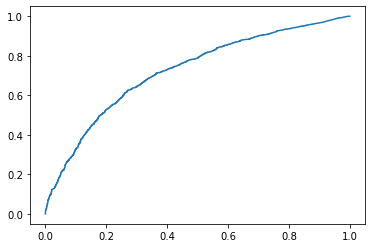

In [38]:
#plot ROC/AUC curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df2[['Helpful']], probas[:,1])[0], roc_curve(df2[['Helpful']], probas[:,1])[1])

In [39]:
# ROC/AUC score
y_score = probas
test2 = np.array(list(df2.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2
roc_auc_score(y_true, y_score[:,1].T)

0.7233579183657989

#### Notes
The Bag of Words model performs poorly with only 72% accuracy.

## Improving Prediction with K-Means Clustering of Reviews
Hypothesis: There's a natural clustering to review vocabulary. I can use the most descriptive clusters to simplify the model.

In [40]:
#Apply TfidfVectorizer to review text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [41]:
model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')
vectorizer.fit(df1['Text'])

TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 2),
                stop_words='english')

### Select Top 10 words per cluster

In [102]:
X_train = vectorizer.transform(df1['Text'])
vocab = vectorizer.get_feature_names()
sse_err = []
res = model.fit(X_train)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)

In [111]:
pd.DataFrame(X_train.toarray(), columns = vocab).head()
np.array(vocab)[0:10]
len(vocab)
len(words)

,amazon,best,better,bought,br,br br,buy,coffee,day,did,...,taste,think,time,tried,try,use,used,want,water,way
0,0.000000,0.188065,0.370888,0.000000,0.233798,0.127876,0.177571,0.000000,0.000000,0.0,...,0.153356,0.000000,0.177886,0.186661,0.000000,0.348169,0.000000,0.0,0.412522,0.000000
1,0.000000,0.485839,0.479068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.229771,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.067134,0.000000,0.067184,0.150553,0.508213,0.277968,0.000000,0.373135,0.075655,0.0,...,0.000000,0.145361,0.064446,0.000000,0.069508,0.378412,0.000000,0.0,0.074726,0.070345
3,0.196298,0.000000,0.000000,0.220106,0.743000,0.270924,0.000000,0.000000,0.221212,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.263627,0.000000,0.000000,0.000000,0.000000,0.292832,0.593728,0.0,...,0.436019,0.000000,0.000000,0.000000,0.000000,0.000000,0.270538,0.0,0.000000,0.000000


array(['amazon', 'best', 'better', 'bought', 'br', 'br br', 'buy',
       'coffee', 'day', 'did'], dtype='<U7')

39

17

array([[ 1,  2],
       [ 1,  4],
       [ 1,  0],
       [10,  2],
       [10,  4],
       [10,  0]])

array([1, 1, 1, 0, 0, 0])

array([[10.,  2.],
       [ 1.,  2.]])

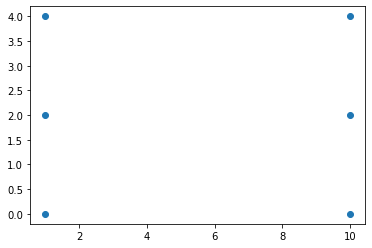

In [141]:
X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
X
plt.scatter(X[:, 0], X[:, 1])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_
kmeans.cluster_centers_

In [134]:
res.cluster_centers_.shape # center에 있는 벡터 array
res.cluster_centers_
sorted_vals
len(vocab[sorted_vals[0]])
vocab[sorted_vals[0]]

(4, 39)

array([[0.56, 0.04, 0.03, 0.05, 0.07, 0.02, 0.09, 0.04, 0.02, 0.03, 0.02,
        0.04, 0.02, 0.03, 0.06, 0.05, 0.07, 0.04, 0.03, 0.06, 0.03, 0.07,
        0.02, 0.05, 0.04, 0.02, 0.11, 0.09, 0.03, 0.03, 0.02, 0.04, 0.03,
        0.02, 0.03, 0.04, 0.01, 0.01, 0.04],
       [0.01, 0.05, 0.05, 0.04, 0.03, 0.01, 0.05, 0.09, 0.03, 0.04, 0.03,
        0.06, 0.04, 0.07, 0.08, 0.08, 0.08, 0.05, 0.05, 0.09, 0.03, 0.11,
        0.05, 0.06, 0.05, 0.03, 0.05, 0.02, 0.06, 0.09, 0.03, 0.05, 0.05,
        0.04, 0.06, 0.04, 0.03, 0.04, 0.03],
       [0.03, 0.03, 0.04, 0.05, 0.06, 0.02, 0.07, 0.02, 0.02, 0.04, 0.04,
        0.04, 0.02, 0.03, 0.04, 0.06, 0.07, 0.04, 0.02, 0.06, 0.03, 0.07,
        0.03, 0.03, 0.04, 0.02, 0.05, 0.55, 0.04, 0.06, 0.03, 0.04, 0.03,
        0.03, 0.07, 0.04, 0.03, 0.02, 0.03],
       [0.04, 0.03, 0.04, 0.02, 0.64, 0.3 , 0.04, 0.04, 0.04, 0.03, 0.03,
        0.05, 0.04, 0.05, 0.08, 0.07, 0.05, 0.04, 0.04, 0.07, 0.03, 0.09,
        0.04, 0.03, 0.04, 0.03, 0.03, 0.06, 0.05, 0

[array([37, 36, 25, 12,  5, 10,  8, 33, 22, 30, 32, 20, 34, 18,  2, 29, 13,
         9, 28, 17,  7, 24, 11, 38,  1, 35, 31,  3, 23, 15, 14, 19,  4, 16,
        21, 27,  6, 26,  0], dtype=int64),
 array([ 0,  5, 27, 10, 25, 36, 30, 20,  4,  8, 38,  9, 37, 35, 12, 33,  3,
        31, 17,  2, 32, 24, 26, 18,  1, 22,  6, 34, 23, 28, 11, 13, 16, 14,
        15, 19, 29,  7, 21], dtype=int64),
 array([ 7,  5, 37, 25, 18,  8, 12,  1, 30, 32,  0, 33, 36, 23, 13, 20, 38,
        22, 24, 28, 17, 10,  2, 35,  9, 11, 14, 31,  3, 26,  4, 19, 29, 15,
         6, 21, 16, 34, 27], dtype=int64),
 array([ 3,  9, 25, 36, 26, 30, 33, 20,  1, 10, 23, 32,  0, 35,  8, 38,  6,
        12,  2,  7, 24, 22, 18, 17, 31, 28, 37, 16, 34, 11, 13, 29, 27, 15,
        19, 14, 21,  5,  4], dtype=int64)]

39

array(['water', 'want', 'people', 'eat', 'br br', 'does', 'day', 'try',
       'little', 'think', 'tried', 'know', 'use', 'ive', 'better',
       'taste', 'flavor', 'did', 'really', 'im', 'coffee', 'make', 'dont',
       'way', 'best', 'used', 'time', 'bought', 'love', 'good', 'food',
       'just', 'br', 'great', 'like', 'product', 'buy', 'price', 'amazon'],
      dtype='<U7')

### cluster_centers_ndarray of shape (n_clusters, n_features)
Coordinates of cluster centers. 

In [126]:
[i for i in range(0,np.shape(res.cluster_centers_)[0])]
res.cluster_centers_[0]
res.cluster_centers_[0].argsort()

[0, 1, 2, 3]

array([0.56, 0.04, 0.03, 0.05, 0.07, 0.02, 0.09, 0.04, 0.02, 0.03, 0.02,
       0.04, 0.02, 0.03, 0.06, 0.05, 0.07, 0.04, 0.03, 0.06, 0.03, 0.07,
       0.02, 0.05, 0.04, 0.02, 0.11, 0.09, 0.03, 0.03, 0.02, 0.04, 0.03,
       0.02, 0.03, 0.04, 0.01, 0.01, 0.04])

array([37, 36, 25, 12,  5, 10,  8, 33, 22, 30, 32, 20, 34, 18,  2, 29, 13,
        9, 28, 17,  7, 24, 11, 38,  1, 35, 31,  3, 23, 15, 14, 19,  4, 16,
       21, 27,  6, 26,  0], dtype=int64)

In [144]:
len(words)
#top 10 words for each cluster
':'.join(words)

17

'br:price:amazon:buy:just:good:coffee:like:taste:really:product:flavor:use:dont:br br:great:food'

In [142]:
X_train.shape

(21463, 39)

In [150]:
len(vocab)
len(words)
[np.argwhere(vocab==i)[0][0] for i in words]

39

17

[4, 26, 0, 6, 19, 15, 7, 21, 29, 28, 27, 13, 34, 11, 5, 16, 14]

In [147]:
#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]
pd.DataFrame(train_set.toarray(), columns=words)

,br,price,amazon,buy,just,good,coffee,like,taste,really,product,flavor,use,dont,br br,great,food
0,0.233798,0.0,0.000000,0.177571,0.000000,0.433066,0.000000,0.127957,0.153356,0.000000,0.286521,0.0,0.348169,0.000000,0.127876,0.161078,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.372921,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.421841,0.000000,0.208060,0.000000
2,0.508213,0.0,0.067134,0.000000,0.102979,0.156894,0.373135,0.139072,0.000000,0.063456,0.051901,0.0,0.378412,0.236634,0.277968,0.116713,0.192352
3,0.743000,0.0,0.196298,0.000000,0.000000,0.152918,0.000000,0.271094,0.000000,0.000000,0.303516,0.0,0.000000,0.000000,0.270924,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.292832,0.181903,0.436019,0.000000,0.203658,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21458,0.845626,0.0,0.000000,0.093989,0.125377,0.000000,0.145374,0.045152,0.054114,0.030903,0.000000,0.0,0.122858,0.028810,0.428674,0.085259,0.031225
21459,0.000000,0.0,0.000000,0.000000,0.227121,0.230688,0.000000,0.408965,0.245071,0.000000,0.228938,0.0,0.278197,0.000000,0.000000,0.000000,0.000000
21460,0.000000,0.0,0.000000,0.239693,0.191845,0.000000,0.000000,0.518167,0.000000,0.236429,0.000000,0.0,0.000000,0.000000,0.000000,0.217430,0.000000
21461,0.599921,0.0,0.000000,0.000000,0.437622,0.000000,0.000000,0.131334,0.000000,0.000000,0.294082,0.0,0.357357,0.000000,0.131251,0.000000,0.181650


In [154]:
df1.head(); df1.shape
model.labels_; len(model.labels_)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Helpful,cluster
32,19,19,4,mccanns instant oatmeal is great if you must h...,1,2
33,13,13,4,this is a good instant oatmeal from the best o...,1,0
82,15,15,5,i know the product title says molecular gastro...,1,2
158,17,19,5,<span class=tiny> length 026 mins<br ><br ><sp...,1,3
287,13,13,5,this is a fantastic product and i wish it was ...,1,0


(21463, 6)

array([1, 1, 3, ..., 1, 3, 1])

21463

In [71]:
# how many observations are in each cluster
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Helpful
cluster,,,,,
0,11459,11459,11459,11459,11459
1,2501,2501,2501,2501,2501
2,4423,4423,4423,4423,4423
3,3080,3080,3080,3080,3080


In [72]:
# what does each cluster look like
df1.groupby('cluster').mean()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful
cluster,,,,
0,15.774500,21.019635,3.205952,0.770137
1,27.302679,30.828069,3.830068,0.862855
2,22.440877,26.650916,3.548044,0.855754
3,25.928247,31.241558,3.598377,0.842532


In [73]:
# correlation matrix
df1.corr()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful,cluster
HelpfulnessNumerator,1.000000,0.975746,0.145338,0.228370,0.115878
HelpfulnessDenominator,0.975746,1.000000,0.048775,0.080156,0.107569
Score,0.145338,0.048775,1.000000,0.457537,0.095538
Helpful,0.228370,0.080156,0.457537,1.000000,0.088838
cluster,0.115878,0.107569,0.095538,0.088838,1.000000


#### Notes
There doesn't seem to be a clear trend to the clusters. I cannot make a silhoute coefficient plot due to computer storage capacity, so I chose 4 clusters. With more clusters, the number of overlapping "top words" from each cluster seems to increase. In total there are only 30 "top words" instead of 40, because some top words overlapped among clusters. There may be some common words that I should consider removing in further analysis, like "food"" or "coffee".

## Logistic Regression to Predict Review Helpfulness with Top Cluster Words 

In [155]:
print(train_set.shape)

(21463, 17)


In [156]:
#add Score column to top words
import scipy as scipy

score = np.array(list(df1.Score))
score = score.reshape(21463, 1)
features = scipy.sparse.hstack((train_set,scipy.sparse.csr_matrix(score)))
features = scipy.sparse.csr_matrix(features)

In [157]:
features.shape
features.toarray()

(21463, 18)

array([[0.23, 0.  , 0.  , ..., 0.16, 0.  , 4.  ],
       [0.  , 0.  , 0.  , ..., 0.21, 0.  , 4.  ],
       [0.51, 0.  , 0.07, ..., 0.12, 0.19, 5.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.22, 0.  , 1.  ],
       [0.6 , 0.  , 0.  , ..., 0.  , 0.18, 2.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

In [158]:
#find best logistic regression parameters
from sklearn.linear_model import LogisticRegression
feature_set = features
gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)


gs.fit(features, df1.Helpful)
gs.best_score_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01,
                               0.001, 0.0001],
                         'class_weight': [None, 'balanced']},
             scoring='roc_auc')

0.8284704575731066

In [159]:
print(gs.best_estimator_)

LogisticRegression(C=100, class_weight='balanced')


In [160]:
y_pred = gs.predict(feature_set)

In [161]:
# Coefficients represent the log-odds
print(gs.best_estimator_.coef_)
print(gs.best_estimator_.intercept_)

[[0.08 1.04 0.65 0.23 0.33 0.21 1.12 0.11 0.46 0.82 0.26 1.11 0.72 0.14
  1.7  0.99 1.16 0.77]]
[-2.79]


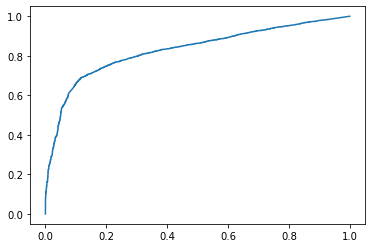

In [162]:
#roc curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df1[['Helpful']], probas[:,1])[0], roc_curve(df1[['Helpful']], probas[:,1])[1])

In [87]:
#roc auc score
y_score = probas
test2 = np.array(list(df1.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2

roc_auc_score(y_true, y_score[:,1].T)

0.8259733902902583

Confusion matrix, without normalization
[[ 3353   747]
 [ 4652 12711]]


<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.82 0.18]
 [0.27 0.73]]


<Figure size 432x288 with 0 Axes>

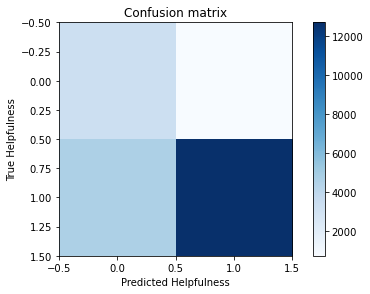

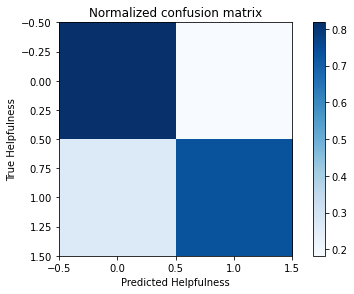

In [88]:
#plot a confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True Helpfulness')
    plt.xlabel('Predicted Helpfulness')


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [89]:
#view top parameters
words.extend(['score'])
sorted(zip(words,gs.best_estimator_.coef_[0]),key=lambda x:x[1])

[('dont', -0.2823005005436938),
 ('like', -0.26760460054050395),
 ('br', -0.25653059862495864),
 ('product', -0.07150251691408084),
 ('good', -0.0035581846286520335),
 ('buy', 0.025649926822248818),
 ('just', 0.06550647795808039),
 ('taste', 0.3228607722833471),
 ('tea', 0.32984481568220486),
 ('amazon', 0.6942353210824066),
 ('score', 0.7581424631897834),
 ('really', 0.84362371903142),
 ('water', 0.8446781893361152),
 ('use', 0.8592851791688694),
 ('coffee', 0.8994378325846745),
 ('price', 1.187411384959265),
 ('great', 1.3326997224069992),
 ('cup', 1.386776386673741),
 ('food', 1.4448050595218023),
 ('flavor', 1.4982957560962367),
 ('br br', 2.13090010386843)]

#### Notes
There seem to be common words that I should remove from the text in further analysis, like food, product, or Amazon.

My model is 82% accurate, which is 10% increase in accuracy over the Bag of Words model.

## Recommendations
Price, Flavor, and Great are the top indicators of a helpful review. This indicates a possible bias among customers to mark a review as helpful when the review is positive. Eating, Like, Don't, Order, Good, and Eat are all negatively correlated with a helpful review, which is difficult to interpret. These may be more common words to remove.

Moving forward, I would explore the following methods to improve this analysis:

1) I would explore alternative definitions of an "unhelpful" review. For example, reviews that are not market as "helpful" could be classified as unhelpful. This may help counter consumer-bias if consumers are less likely to mark a negative review as helpful, because it did not enable them to buy the product. This problem requires more domain expertise on consumer behavior.

2) I would make Score into dummy variables to further explore potential biases related to Score. For example, consumers may find that reviews with a score of 1 or 5 are more helpful than scores of 2, 3, and 4.

3) I would explore curating a domain-specific dictionary for this project to avoid common food words and Amazon words in reviews.

4) I would explore using these findings as a guide for reviewers. For example, when writing a review, Amazon could show "Tips for writing a helpful review": "Describe the flavor of this product" ("Flavor" is the most highly correlated parameter with "helpfulness"), "Describe the value of this product compared to its price", etc.